In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick   
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as sk_auc
import sys, os
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_one import feature_engineering_one
from ift6758.data.feature_engineering_pt2 import feature_engineering_two
import ift6758.data.advanced_models as adv
import wandb
import joblib
import pandas as pd
from sklearn.metrics import roc_auc_score

In [3]:
### MAY NEED TO DELETE ALLSHOTGOALS2.CSV AND RUN THIS NOTEBOOK TO MAKE IT WORK"
def compute_auc_roc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = sk_auc(fpr, tpr)
    print(f"AUC: {roc_auc:.3f}")
    return fpr, tpr, roc_auc

In [ ]:
# Percentiles of predicted probabilities
def goal_rate_vs_percentile(y_test, y_pred_proba):
    df_val_percentile = pd.DataFrame({
        'y_true': y_test,
        'y_prob': y_pred_proba
    })

    df_val_percentile = df_val_percentile.sort_values(by='y_prob', ascending=False)

    df_val_percentile['percentile'] = np.linspace(100, 0, len(df_val_percentile))
    df_val_percentile['percentile_bin'] = pd.qcut(df_val_percentile['percentile'], q=100, labels=False)
    goal_rate = df_val_percentile.groupby('percentile_bin')['y_true'].mean()
    return goal_rate.index, goal_rate.values

In [ ]:
#Cumulative proportion of goals 
def cumulative_goal_curve(y_test, y_pred_proba):
    # DataFrame with true labels + predicted probabilities
    df_val_cum = pd.DataFrame({
        'y_true': y_test,
        'y_prob': y_pred_proba
    })

    # 1. Sort by predicted probability (highest → lowest)
    df_val_cum = df_val_cum.sort_values(by='y_prob', ascending=False).reset_index(drop=True)

    df_val_cum['cumulative_goals'] = df_val_cum['y_true'].cumsum()

    total_goals = df_val_cum['y_true'].sum()
    df_val_cum['cumulative_goal_percent'] = (df_val_cum['cumulative_goals'] / total_goals) * 100

    df_val_cum['percentile'] = np.linspace(100, 0, len(df_val_cum))
    return df_val_cum

In [6]:
df_eng_one = feature_engineering_one(years=range(2020, 2021))

100%|██████████| 952/952 [00:29<00:00, 32.66it/s]


In [69]:
# Load your test set
df_eng_one["game_id"] = df_eng_one["game_id"].astype(str)

df_eng_one["game_id"] = df_eng_one["game_id"].astype(str)

df_eng_one["game_type"] = df_eng_one["game_id"].str[4:6]

df_eng_one_regular = df_eng_one[df_eng_one["game_type"] == "02"].copy().reset_index(drop=True)
df_eng_one_playoff = df_eng_one[df_eng_one["game_type"] == "03"].copy().reset_index(drop=True)

y_test_eng_one_regular = df_eng_one_regular['is_goal']
X_test_eng_one_regular = df_eng_one_regular.drop(columns=['is_goal'])
numerical_cols = X_test_eng_one_regular.select_dtypes(include=['number']).columns
median_values = X_test_eng_one_regular[numerical_cols].median()
X_test_eng_one_regular[numerical_cols] = X_test_eng_one_regular[numerical_cols].fillna(median_values)

y_test_eng_one_playoff = df_eng_one_playoff['is_goal']
X_test_eng_one_playoff = df_eng_one_playoff.drop(columns=['is_goal'])
numerical_cols = X_test_eng_one_playoff.select_dtypes(include=['number']).columns
median_values = X_test_eng_one_playoff[numerical_cols].median()
X_test_eng_one_playoff[numerical_cols] = X_test_eng_one_playoff[numerical_cols].fillna(median_values)

In [70]:
df = feature_engineering_two(years=range(2016, 2021), download_from_scratch=False)

In [71]:
# Load your test set
df_train_val = df[df['season'] < 20202021]
df_eng_two = df[df['season'] == 20202021]
df_eng_two["game_id"] = df_eng_two["game_id"].astype(str)
df_eng_two["game_id"] = df_eng_two["game_id"].astype(str)
df_eng_two["game_type"] = df_eng_two["game_id"].str[4:6]
df_eng_two_regular = df_eng_two[df_eng_two["game_type"] == "02"].copy().reset_index(drop=True)
df_eng_two_playoff = df_eng_two[df_eng_two["game_type"] == "03"].copy().reset_index(drop=True)
y_test_eng_two_regular = df_eng_two_regular['is_goal']
X_test_eng_two_regular = df_eng_two_regular.drop(columns=['is_goal'])
y_test_eng_two_playoff = df_eng_two_playoff['is_goal']
X_test_eng_two_playoff = df_eng_two_playoff.drop(columns=['is_goal'])

C:\Users\salee\AppData\Local\Temp\ipykernel_34288\2520279811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng_two["game_id"] = df_eng_two["game_id"].astype(str)
C:\Users\salee\AppData\Local\Temp\ipykernel_34288\2520279811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng_two["game_id"] = df_eng_two["game_id"].astype(str)
C:\Users\salee\AppData\Local\Temp\ipykernel_34288\2520279811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [72]:
X_test_eng_two_regular.columns

Index(['game_id', 'season', 'game_time', 'period', 'period_time', 'event_type',
       'team_id', 'team_name', 'coordinates_x', 'coordinates_y', 'shooter',
       'goalie', 'shot_type', 'empty_net', 'strength', 'situation_code',
       'previous_event_name', 'previous_event_x', 'previous_event_y',
       'previous_event_timeperiod', 'isHomeTeam', 'friendly_skaters',
       'opponent_skaters', 'zone_code', 'current_event_timeseconds',
       'previous_event_timeseconds', 'time_since_last_event', 'rebound',
       'distance_from_last_event', 'angle_shot_prev', 'angle_shot', 'speed',
       'angle_change', 'distance_shot', 'game_seconds_true', 'game_type'],
      dtype='object')

In [73]:
def adjustments(df2):
    X = df2[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
            'distance_shot', 'angle_shot','shot_type','previous_event_name',
            'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
            'previous_event_x','previous_event_y','distance_from_last_event', 'time_since_last_event',
            'rebound','angle_change','speed']]
        
    X = X.copy()
    X['rebound'] = X['rebound'].astype(int)
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns
    median_values = X[numerical_cols].median()
    X.loc[:, numerical_cols] = X[numerical_cols].fillna(median_values)
    X.loc[:, categorical_cols] = X[categorical_cols].fillna('Unknown')
    X = adv._calculate_time_second(X)
    X = adv._calculate_period_second(X)
    X = X.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])
    return X

X_test_eng_two_regular = adjustments(X_test_eng_two_regular)
X_test_eng_two_playoff = adjustments(X_test_eng_two_playoff)
y_train_val = df_train_val['is_goal']
X_train_val = df_train_val.drop(columns=['is_goal'])
X_train_val = adjustments(X_train_val)

In [74]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

exclude_cols = ['shot_type', 'previous_event_name', 'rebound']

num_cols = [
    col for col in X_train2.columns
    if col not in exclude_cols and X_train2[col].dtype in ['float64', 'int64']
]

scaler = StandardScaler()
X_train2[num_cols] = scaler.fit_transform(X_train2[num_cols])
X_test_eng_two_regular[num_cols] = scaler.transform(X_test_eng_two_regular[num_cols])
X_test_eng_two_playoff[num_cols] = scaler.transform(X_test_eng_two_playoff[num_cols])

X_train2, ohe = adv.change_to_one_hot(
    X_train2, ['shot_type', 'previous_event_name'], ohe=None
)

X_test_eng_two_regular, _ = adv.change_to_one_hot(
    X_test_eng_two_regular, ['shot_type', 'previous_event_name'], ohe=ohe
)

X_test_eng_two_playoff, _ = adv.change_to_one_hot(
    X_test_eng_two_playoff, ['shot_type', 'previous_event_name'], ohe=ohe
)


In [75]:


# Initialize W&B API
api = wandb.Api()

# List of saved model artifact names (must match your W&B artifact names)
artifact_names = [
    "model1-distance",
    "model2-angle",
    "model3-distance-angle",
    "xgb_all_features",
    "gridsearch_best"   # if you saved that one
]

# Your W&B entity/project
ENTITY = "IFT6758-2025-B1"
PROJECT = "IFT6758-2025-B01"

models = {}

for name in artifact_names:
    full_name = f"{ENTITY}/{PROJECT}/{name}:latest"
    print(f"Downloading {full_name} ...")
    artifact = api.artifact(full_name, type="model")
    artifact_dir = artifact.download()
    model_path = f"{artifact_dir}/model.joblib"  
    model = joblib.load(model_path)
    models[name] = model


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


In [76]:

from sklearn.calibration import CalibratedClassifierCV
y_pred_proba_1_regular = models["model1-distance"].predict_proba(X_test_eng_one_regular[["distance_to_net"]])[:, 1]
y_pred_proba_2_regular = models["model2-angle"].predict_proba(X_test_eng_one_regular[["shot_angle"]])[:, 1]
y_pred_proba_3_regular = models["model3-distance-angle"].predict_proba(X_test_eng_one_regular[["distance_to_net", "shot_angle"]])[:, 1]
for df in [X_test_eng_two_regular, X_test_eng_two_playoff, X_train2]:
    if 'previous_event_name_delayed-penalty' in df.columns:
        df.drop(columns='previous_event_name_delayed-penalty', inplace=True)

X_test_eng_two_regular_2 = X_test_eng_two_regular.drop(columns='time_since_last_event').copy()

X_train2_clean = X_train2.drop(columns='time_since_last_event').copy()
calibrated_xgb = CalibratedClassifierCV(models["xgb_all_features"], method='isotonic', cv="prefit")
calibrated_xgb.fit(X_train2_clean, y_train2)
y_pred_proba_4_regular_rel = calibrated_xgb.predict_proba(X_test_eng_two_regular_2)[:, 1]

y_pred_proba_4_regular = models["xgb_all_features"].predict_proba(X_test_eng_two_regular_2)[:, 1]
y_pred_proba_5_regular = models["gridsearch_best"].predict_proba(X_test_eng_two_regular)[:, 1]

y_pred_proba_1_playoff = models["model1-distance"].predict_proba(X_test_eng_one_playoff[["distance_to_net"]])[:, 1]
y_pred_proba_2_playoff = models["model2-angle"].predict_proba(X_test_eng_one_playoff[["shot_angle"]])[:, 1]
y_pred_proba_3_playoff = models["model3-distance-angle"].predict_proba(X_test_eng_one_playoff[["distance_to_net", "shot_angle"]])[:, 1]

X_test_eng_two_playoff_2 = X_test_eng_two_playoff.drop(columns='time_since_last_event').copy()

y_pred_proba_4_playoff_rel = calibrated_xgb.predict_proba(X_test_eng_two_playoff_2)[:, 1]

y_pred_proba_4_playoff = models["xgb_all_features"].predict_proba(X_test_eng_two_playoff_2)[:, 1]
y_pred_proba_5_playoff = models["gridsearch_best"].predict_proba(X_test_eng_two_playoff)[:, 1]

c:\Users\salee\anaconda3\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [77]:
curves_regular = {}
for i, (y_pred, label, y_test) in enumerate([
    (y_pred_proba_1_regular, "Model 1 (Distance)", y_test_eng_one_regular),
    (y_pred_proba_2_regular, "Model 2 (Angle)", y_test_eng_one_regular),
    (y_pred_proba_3_regular, "Model 3 (Distance + Angle)", y_test_eng_one_regular),
    (y_pred_proba_4_regular, "Model 4 (XGBoost All Features)", y_test_eng_two_regular),
    (y_pred_proba_5_regular, "Model 5 (GridSearch All Features)", y_test_eng_two_regular)
]):
    fpr, tpr, auc = compute_auc_roc(y_test, y_pred)
    pctl, goal_rate = goal_rate_vs_percentile(y_test, y_pred)
    df_cum = cumulative_goal_curve(y_test, y_pred)
    curves_regular[label] = dict(fpr=fpr, tpr=tpr, auc=auc,
                         pctl=pctl, goal_rate=goal_rate,
                         df_cum=df_cum, preds=y_pred)
    print(f"{label}: AUC = {auc:.3f}")

AUC: 0.699
Model 1 (Distance): AUC = 0.699
AUC: 0.509
Model 2 (Angle): AUC = 0.509
AUC: 0.700
Model 3 (Distance + Angle): AUC = 0.700
AUC: 0.724
Model 4 (XGBoost All Features): AUC = 0.724
AUC: 0.732
Model 5 (GridSearch All Features): AUC = 0.732


In [78]:
curves_playoff = {}
for i, (y_pred, label, y_test) in enumerate([
    (y_pred_proba_1_playoff, "Model 1 (Distance)", y_test_eng_one_playoff),
    (y_pred_proba_2_playoff, "Model 2 (Angle)", y_test_eng_one_playoff),
    (y_pred_proba_3_playoff, "Model 3 (Distance + Angle)", y_test_eng_one_playoff),
    (y_pred_proba_4_playoff, "Model 4 (XGBoost All Features)", y_test_eng_two_playoff),
    (y_pred_proba_5_playoff, "Model 5 (GridSearch All Features)", y_test_eng_two_playoff)
]):
    fpr, tpr, auc = compute_auc_roc(y_test, y_pred)
    pctl, goal_rate = goal_rate_vs_percentile(y_test, y_pred)
    df_cum = cumulative_goal_curve(y_test, y_pred)
    curves_playoff[label] = dict(fpr=fpr, tpr=tpr, auc=auc,
                         pctl=pctl, goal_rate=goal_rate,
                         df_cum=df_cum, preds=y_pred)
    print(f"{label}: AUC = {auc:.3f}")

AUC: 0.676
Model 1 (Distance): AUC = 0.676
AUC: 0.508
Model 2 (Angle): AUC = 0.508
AUC: 0.677
Model 3 (Distance + Angle): AUC = 0.677
AUC: 0.700
Model 4 (XGBoost All Features): AUC = 0.700
AUC: 0.706
Model 5 (GridSearch All Features): AUC = 0.706


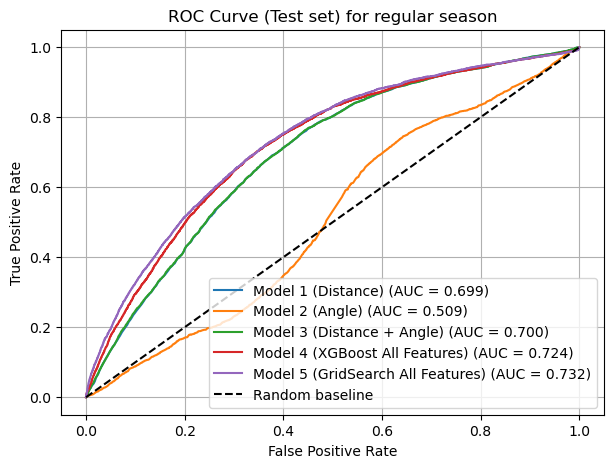

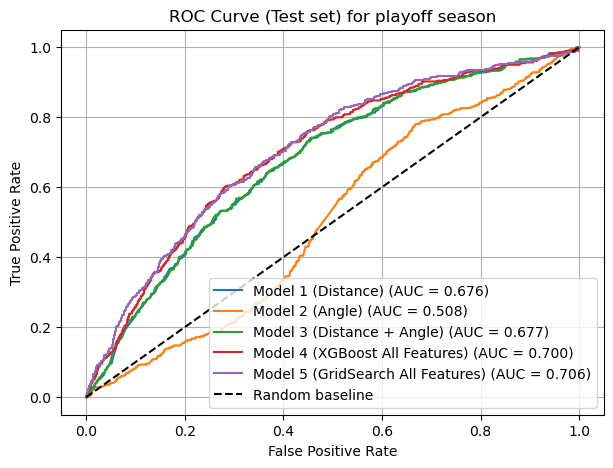

In [79]:
def plot_roc(curves, type):
    plt.figure(figsize=(7,5))
    for label, data in curves.items():
        plt.plot(data["fpr"], data["tpr"], label=f"{label} (AUC = {data['auc']:.3f})")
    plt.plot([0,1],[0,1],'k--', label='Random baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Test set) for {type} season")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_roc(curves_regular, 'regular')
plot_roc(curves_playoff, 'playoff')

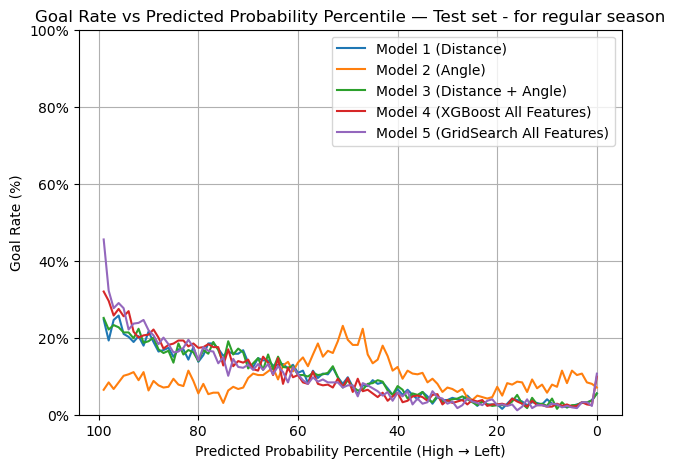

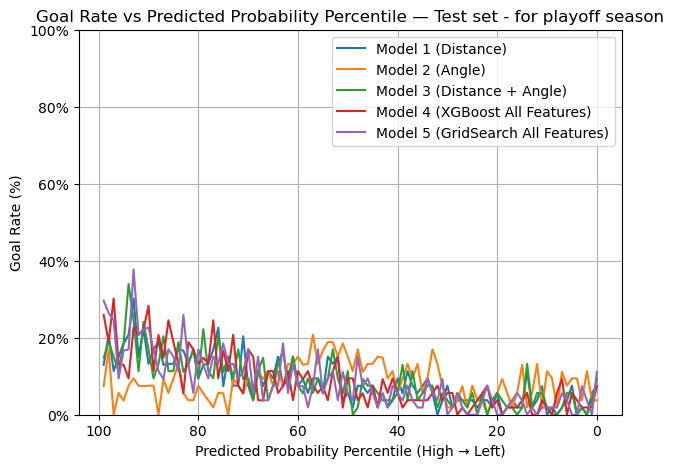

In [80]:
def plot_goal_rate(curves, type):
    plt.figure(figsize=(7,5))
    for label, data in curves.items():
        plt.plot(data["pctl"], data["goal_rate"]*100, label=label)
    plt.gca().invert_xaxis()
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.ylim(0,100)
    plt.xlabel("Predicted Probability Percentile (High → Left)")
    plt.ylabel("Goal Rate (%)")
    plt.title(f"Goal Rate vs Predicted Probability Percentile — Test set - for {type} season")
    plt.legend(); plt.grid(True); plt.show()
plot_goal_rate(curves_regular, 'regular')
plot_goal_rate(curves_playoff, 'playoff')

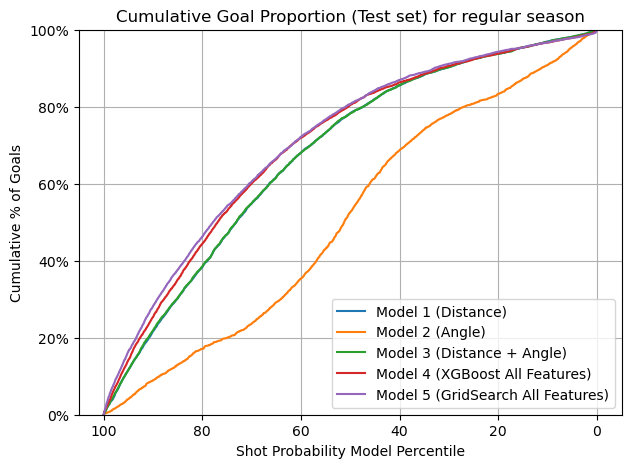

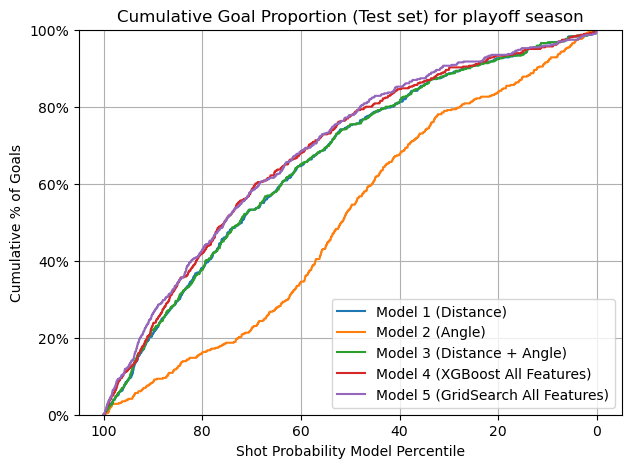

In [81]:
def plot_cummulative(curves, type) : 
    plt.figure(figsize=(7,5))
    for label, data in curves.items():
        plt.plot(data["df_cum"]["percentile"], data["df_cum"]["cumulative_goal_percent"], label=label)
    plt.gca().invert_xaxis()
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.ylim(0, 100)
    plt.xlabel("Shot Probability Model Percentile")
    plt.ylabel("Cumulative % of Goals")
    plt.title(f"Cumulative Goal Proportion (Test set) for {type} season")
    plt.legend(); plt.grid(True); plt.show()
plot_cummulative(curves_regular, 'regular')
plot_cummulative(curves_playoff, 'playoff')

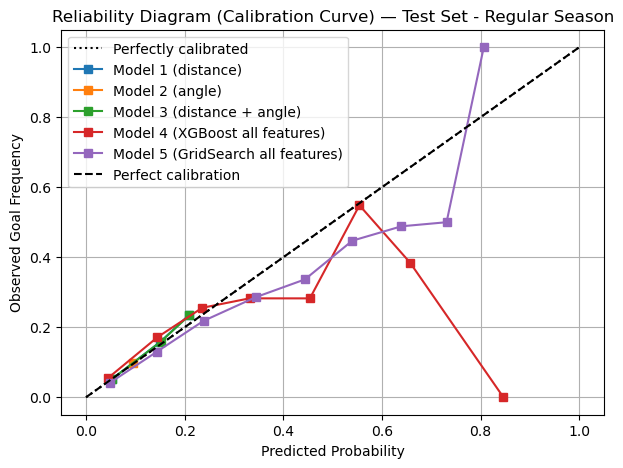

In [82]:
plt.figure(figsize=(7,5))

# Model 1 (distance)
CalibrationDisplay.from_predictions(
    y_test_eng_one_regular,
    y_pred_proba_1_regular,
    n_bins=10,
    name="Model 1 (distance)",
    ax=plt.gca()
)

# Model 2 (angle)
CalibrationDisplay.from_predictions(
    y_test_eng_one_regular,
    y_pred_proba_2_regular,
    n_bins=10,
    name="Model 2 (angle)",
    ax=plt.gca()
)

# Model 3 (distance + angle)
CalibrationDisplay.from_predictions(
    y_test_eng_one_regular,
    y_pred_proba_3_regular,
    n_bins=10,
    name="Model 3 (distance + angle)",
    ax=plt.gca()
)

# Model 4 (random baseline)
CalibrationDisplay.from_predictions(
    y_test_eng_two_regular,
    y_pred_proba_4_regular_rel,
    n_bins=10,
    name="Model 4 (XGBoost all features)",
    ax=plt.gca()
)


# Model 5 (XGBoost all features)
CalibrationDisplay.from_predictions(
    y_test_eng_two_regular,
    y_pred_proba_5_regular,
    n_bins=10,
    name="Model 5 (GridSearch all features)",
    ax=plt.gca()
)

plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Goal Frequency")
plt.title("Reliability Diagram (Calibration Curve) — Test Set - Regular Season")
plt.legend()
plt.grid(True)
plt.show()

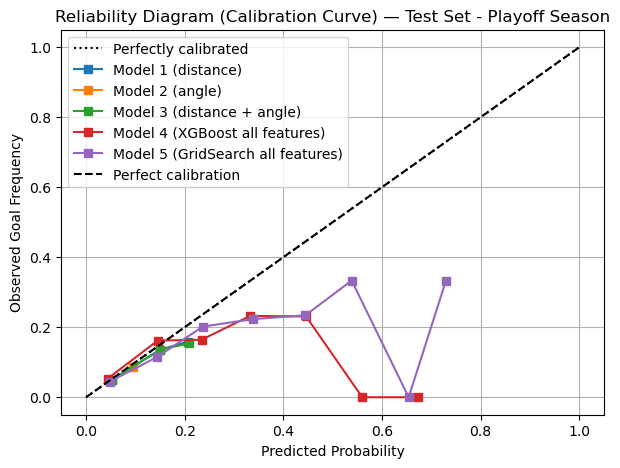

In [83]:
plt.figure(figsize=(7,5))

# Model 1 (distance)
CalibrationDisplay.from_predictions(
    y_test_eng_one_playoff,
    y_pred_proba_1_playoff,
    n_bins=10,
    name="Model 1 (distance)",
    ax=plt.gca()
)

# Model 2 (angle)
CalibrationDisplay.from_predictions(
    y_test_eng_one_playoff,
    y_pred_proba_2_playoff,
    n_bins=10,
    name="Model 2 (angle)",
    ax=plt.gca()
)

# Model 3 (distance + angle)
CalibrationDisplay.from_predictions(
    y_test_eng_one_playoff,
    y_pred_proba_3_playoff,
    n_bins=10,
    name="Model 3 (distance + angle)",
    ax=plt.gca()
)

# Model 4 (random baseline)
CalibrationDisplay.from_predictions(
    y_test_eng_two_playoff,
    y_pred_proba_4_playoff_rel,
    n_bins=10,
    name="Model 4 (XGBoost all features)",
    ax=plt.gca()
)

# Model 5 (XGBoost all features)
CalibrationDisplay.from_predictions(
    y_test_eng_two_playoff,
    y_pred_proba_5_playoff,
    n_bins=10,
    name="Model 5 (GridSearch all features)",
    ax=plt.gca()
)

plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Goal Frequency")
plt.title("Reliability Diagram (Calibration Curve) — Test Set - Playoff Season")
plt.legend()
plt.grid(True)
plt.show()